In [2]:
# Manage imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set up model
# Model data downloaded from "https://github.com/tamim662/YOLO-Fish"
net = cv2.dnn.readNetFromDarknet('./model/yolo-fish-2.cfg', './model/merge_yolo-fish-2.weights')
model = cv2.dnn_DetectionModel(net)

# Use model to find fish
def detect_fish(img):
    """
    Find fish in img
    :param img: single frame in which to detect fish
    :return: array containing bounding box descriptors
    """
    fish_boxes = []
    # High nms threshold accounts for close proximity of fish in schools
    _, scores, boxes = model.detect(img, nmsThreshold=0.6)
    for score, box in zip(scores, boxes):
        if score >= 0.5:
            fish_boxes.append(box)

    return fish_boxes

In [4]:
# Load in video
footage = cv2.VideoCapture("./media/clip1-NassauGrouperAgainstTheClock-BelugaSmileProductions.mp4")

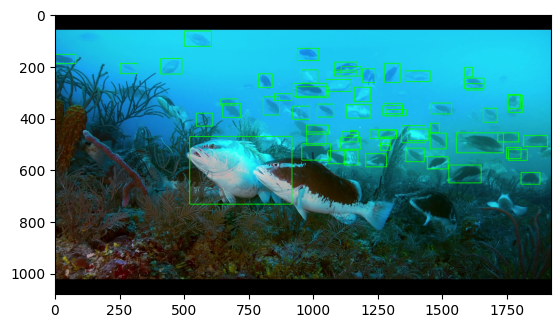

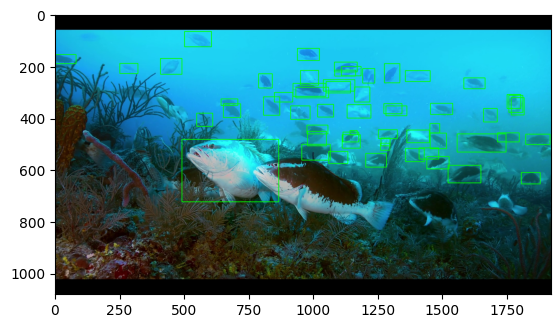

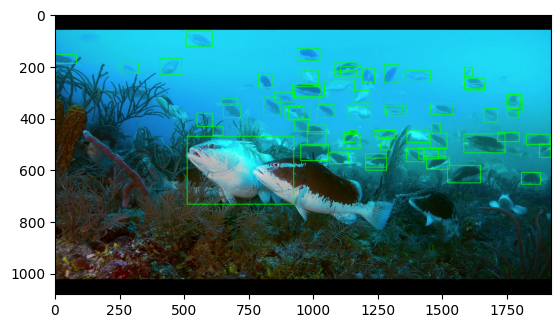

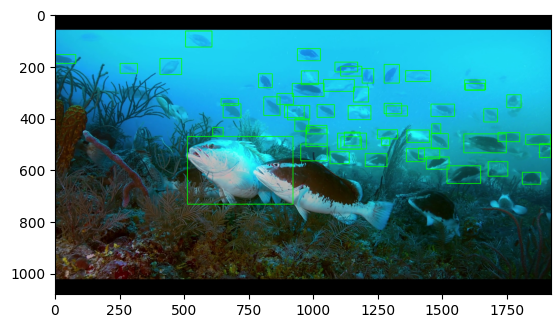

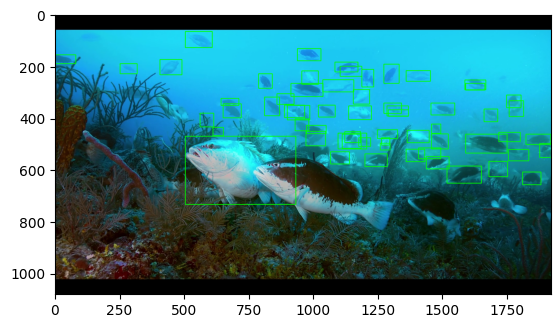

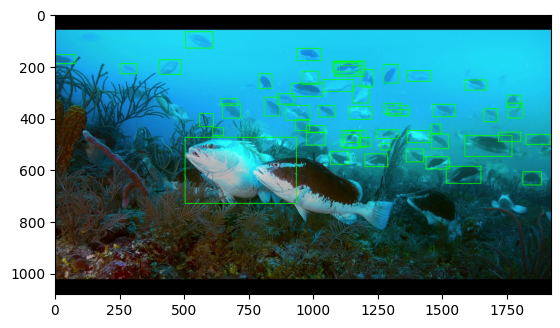

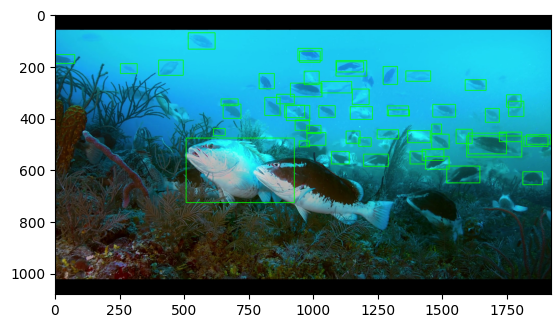

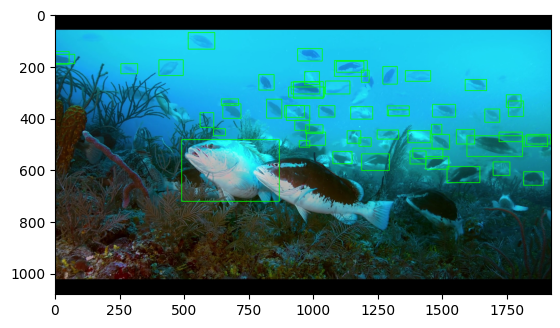

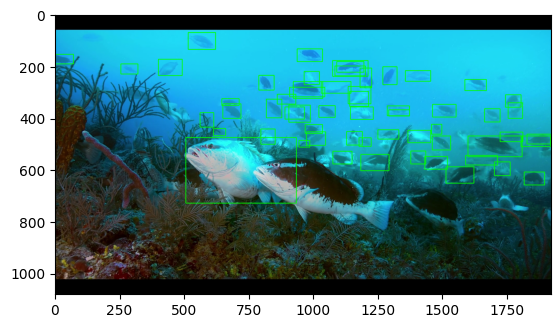

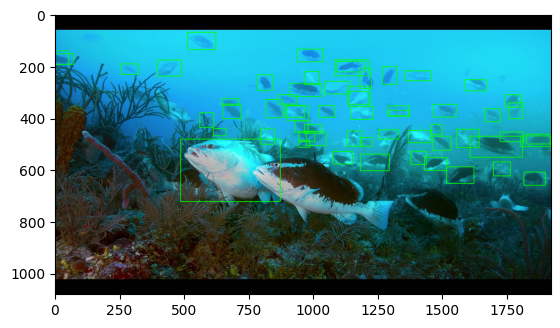

In [7]:
# Display options
DISPLAY_CV2 = "cv2"
DISPLAY_PLT = "plt"
display_method = DISPLAY_PLT

DISPLAY_TEST = "test"
DISPLAY_FULL = "full"
display_length = DISPLAY_TEST

TEST_LENGTH = 10

# Select frame and apply detection
frame_exists, frame = footage.read()

# Update input size from frame
frame_size = np.shape(frame)
# Integer divide height & width, then multiple by 32 to get an exact multiple
height_nearest_32 = ( frame_size[0] // 32 ) * 32
width_nearest_32 = ( frame_size[1] // 32 ) * 32
model.setInputParams(size=(height_nearest_32, width_nearest_32), scale=1/255)

def process_frame(frame, display_method):
    """
    Run frame through model, mark up with boxes, and display output
    :param frame: img being processed, can be frame from a video
    :param display_method: DISPLAY_PLT (show each frame below code block) or DISPLAY_CV2 (display as popup window)
    """
    # Adjust colours for Jupyter notebook
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Mark up frame with fish locations
    boxes = detect_fish(frame)
    for box in boxes:
        (x, y, w, h) = box
        x2 = x + w
        y2 = y + h
        border_colour = (0, 255, 0)
        border_width = 2
        cv2.rectangle(frame, (x, y), (x2, y2), border_colour, border_width)

    # Display image
    if (display_method == DISPLAY_CV2):
        cv2.imshow('custom window', frame)
        cv2.waitKey(1)
    else: # DISPLAY_PLT
        plt.imshow(frame)
        plt.show()

# Set up display conditions
if (display_method == DISPLAY_CV2):
    scaling_factor = 2
    cv2.namedWindow( 'custom window', cv2.WINDOW_KEEPRATIO )
    cv2.resizeWindow( 'custom window', (frame_size[1] // scaling_factor), (frame_size[0] // scaling_factor) )

# Check number of frames to display
if (display_length == DISPLAY_TEST):
    number_of_frames = TEST_LENGTH
else: # DISPLAY_FULL
    number_of_frames = int( footage.get( cv2.CAP_PROP_FRAME_COUNT ) )

# Process number of frames
frame_count = 0
while frame_count < number_of_frames:
    if frame_exists:
        process_frame(frame, display_method)
        # Get next frame and update count
        frame_exists, frame = footage.read()
        frame_count += 1

footage.release()
cv2.destroyAllWindows()